Gradient values of dog.jpg
[[[ 89 107  59]
  [ 91 108  63]
  [ 98 113  72]
  ...
  [224 230 230]
  [224 230 230]
  [224 230 230]]

 [[ 98 115  71]
  [ 94 111  69]
  [ 93 107  71]
  ...
  [225 231 231]
  [225 231 231]
  [225 231 231]]

 [[ 77  93  56]
  [ 73  89  53]
  [ 92 105  75]
  ...
  [226 232 232]
  [226 232 232]
  [226 232 232]]

 ...

 [[125 134 129]
  [128 137 132]
  [128 137 132]
  ...
  [ 74  82  84]
  [ 72  80  82]
  [ 70  78  80]]

 [[124 133 128]
  [126 135 130]
  [126 135 130]
  ...
  [ 74  82  84]
  [ 73  81  83]
  [ 73  81  83]]

 [[122 131 126]
  [124 133 128]
  [123 132 127]
  ...
  [ 74  82  84]
  [ 75  83  85]
  [ 75  83  85]]]
Gradient values of sky_hostel.jpg
[[[15 14 20]
  [14 13 19]
  [14 13 19]
  ...
  [10  8 13]
  [10  8 13]
  [10  8 13]]

 [[14 13 19]
  [14 13 19]
  [14 13 19]
  ...
  [10  8 13]
  [10  8 13]
  [10  8 13]]

 [[14 13 19]
  [14 13 19]
  [14 13 19]
  ...
  [10  8 13]
  [10  8 13]
  [10  8 13]]

 ...

 [[13  9 10]
  [13  9 10]
  [13  9 10]
  ...


C:\Users\kamalkant\AppData\Local\Temp\ipykernel_10440\779894794.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.subplots()


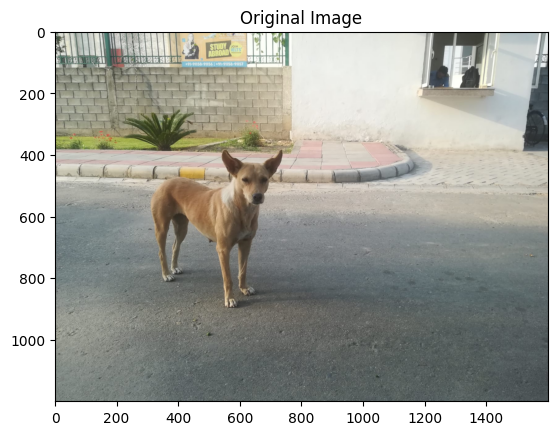

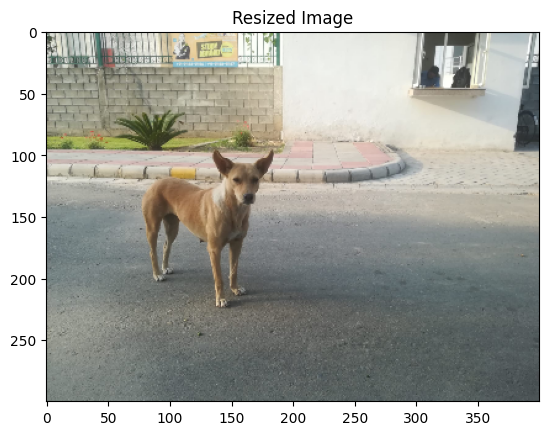

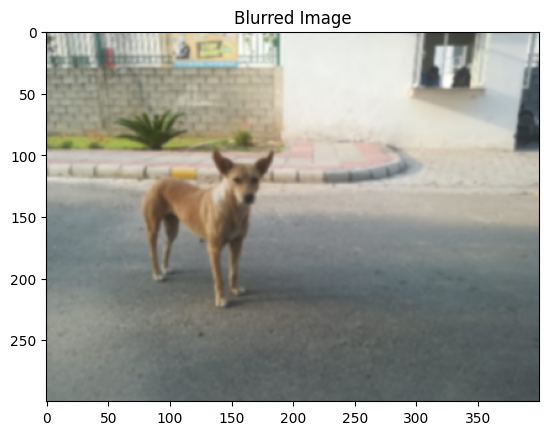

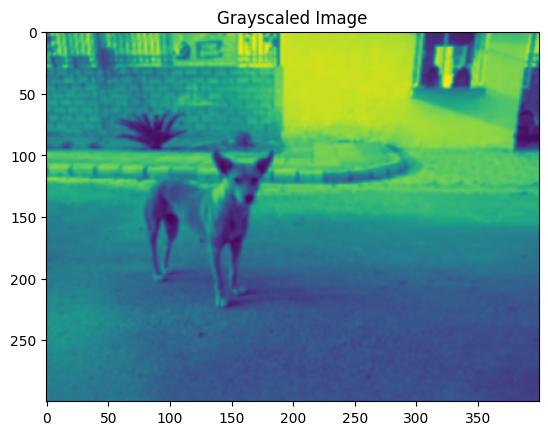

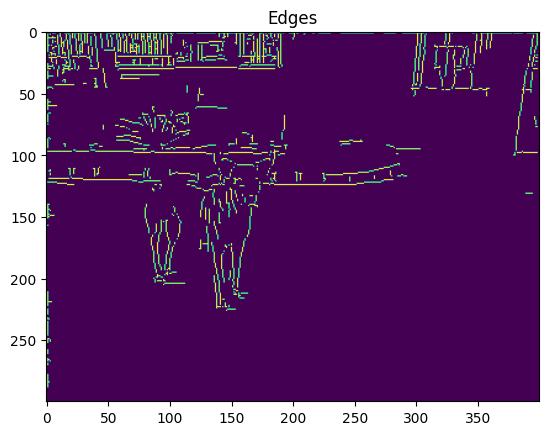

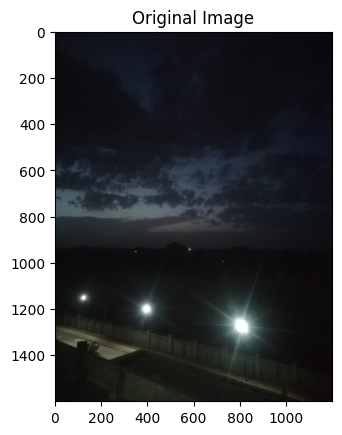

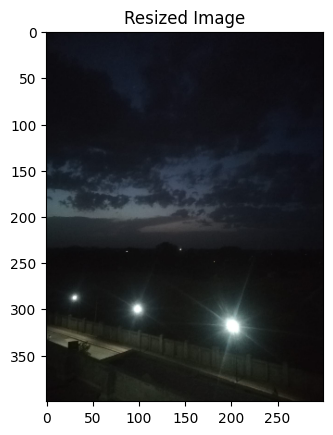

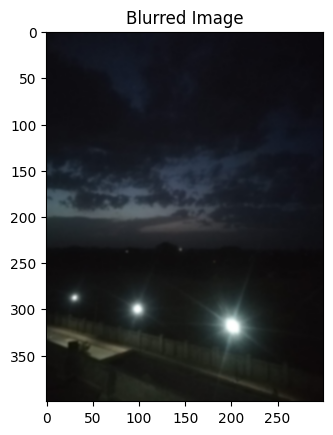

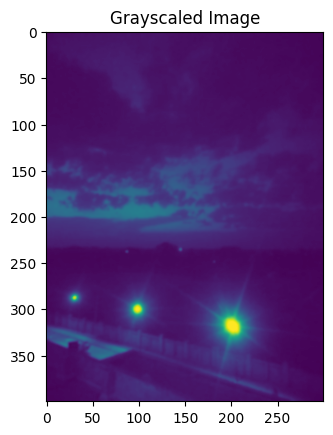

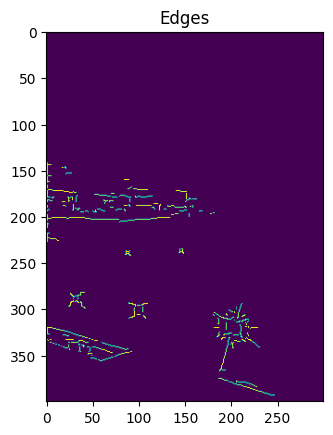

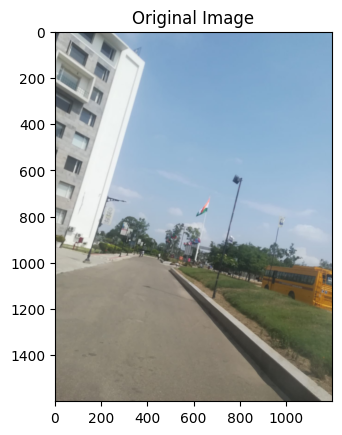

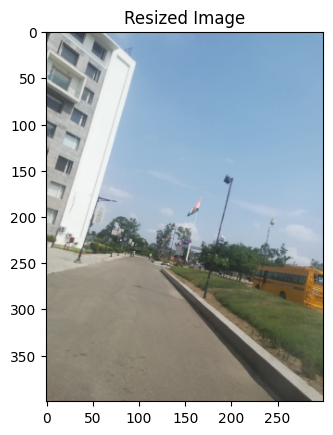

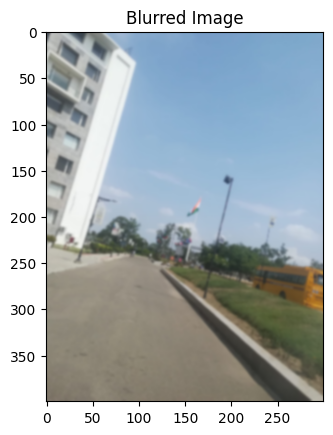

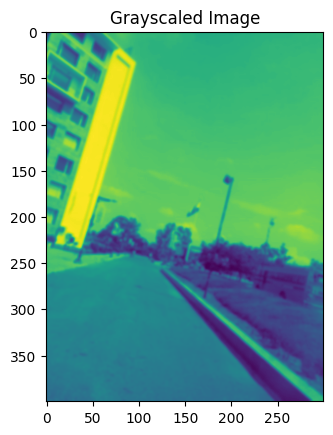

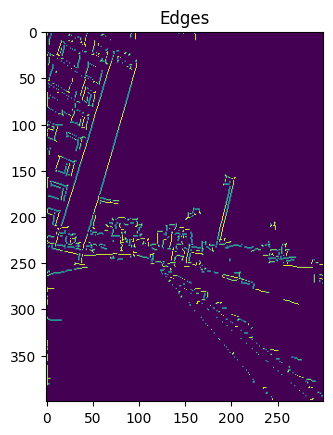

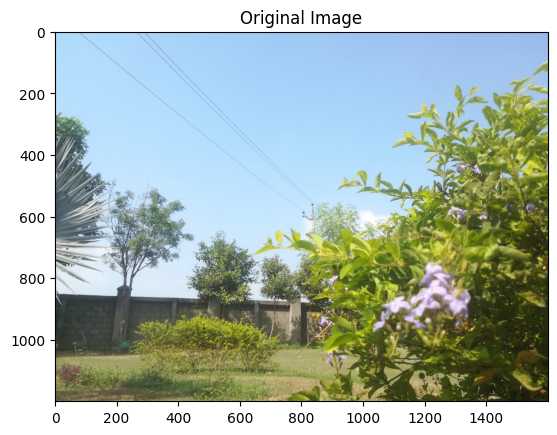

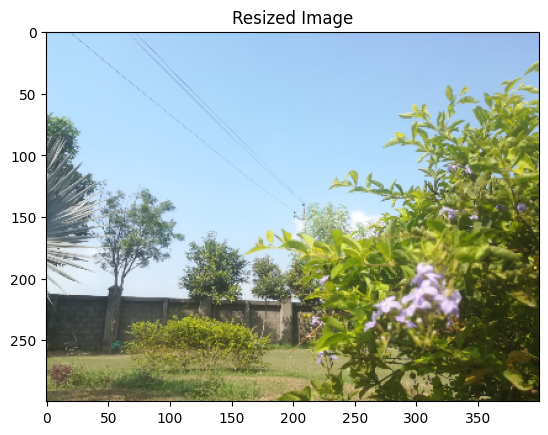

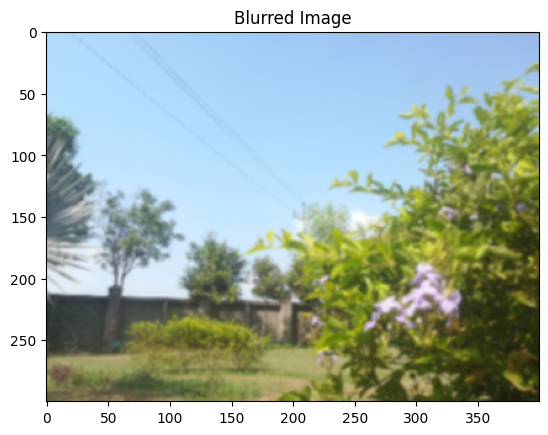

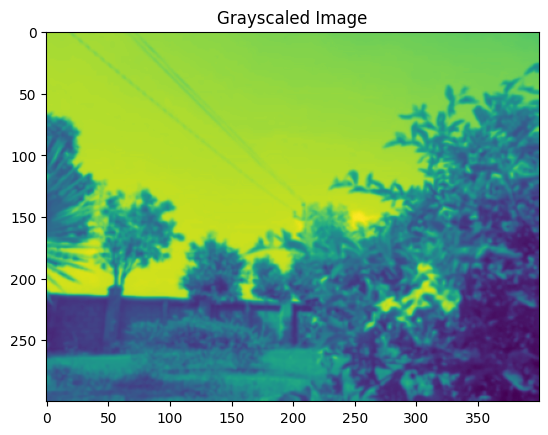

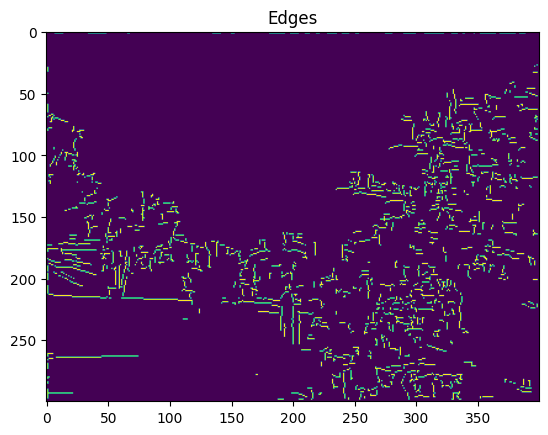

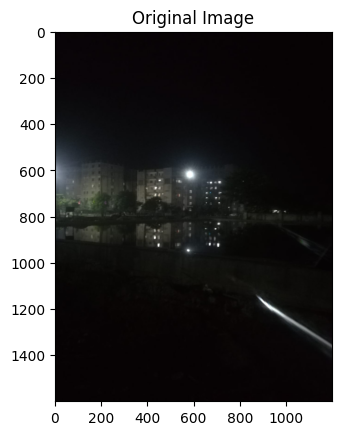

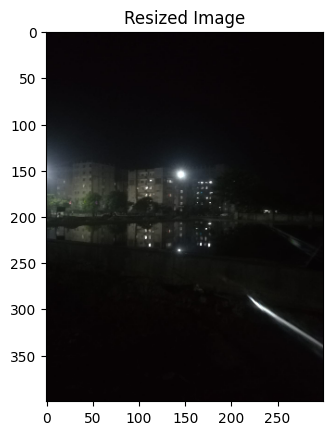

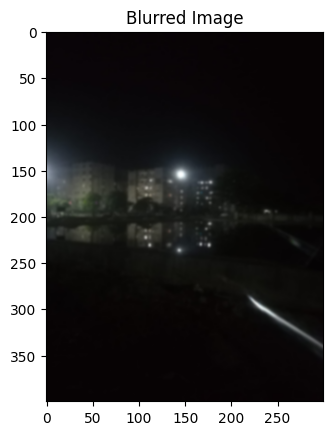

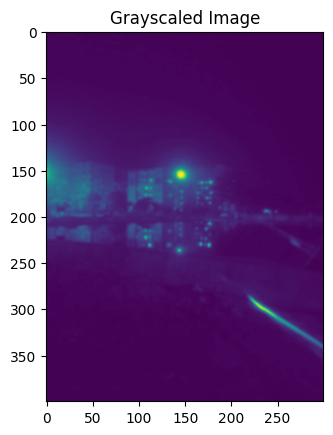

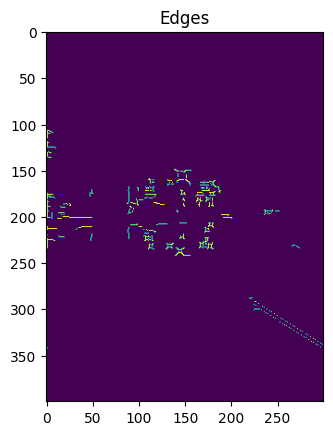

In [71]:
#importing opencv
import cv2
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
%matplotlib inline
import numpy as np
from scipy import ndimage
from __future__ import division
from numpy import array, zeros, abs, sqrt, arctan2, arctan, pi, real
from numpy.fft import fft2, ifft2

def findinggradient(im):
    # Given Sobel operator kernels
    op1 = array([[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]])
    op2 = array([[-1, -2, -1],
                 [ 0,  0,  0],
                 [ 1,  2,  1]])
    kernel1 = zeros(im.shape)
    kernel1[:op1.shape[0], :op1.shape[1]] = op1
    kernel1 = fft2(kernel1)

    kernel2 = zeros(im.shape)
    kernel2[:op2.shape[0], :op2.shape[1]] = op2
    kernel2 = fft2(kernel2)

    fim = fft2(im)
    Gx = real(ifft2(kernel1 * fim)).astype(float)
    Gy = real(ifft2(kernel2 * fim)).astype(float)

    G = sqrt(Gx**2 + Gy**2)
    Theta = arctan2(Gy, Gx) * 180 / pi
    # The direction is rounded to one of four possible angles (namely 0, 45, 90 or 135)
    # https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html
    return G, Theta

def nonmax_suppression(det, phase):
    gmax = zeros(det.shape)
    for i in range(gmax.shape[0]):
        for j in range(gmax.shape[1]):
            if phase[i][j] < 0:
                phase[i][j] += 360

            if ((j + 1) < gmax.shape[1]) and ((j - 1) >= 0) and ((i + 1) < gmax.shape[0]) and ((i - 1) >= 0):
                # 0 degrees
                if (phase[i][j] >= 337.5 or phase[i][j] < 22.5) or (phase[i][j] >= 157.5 and phase[i][j] < 202.5):
                    if det[i][j] >= det[i][j + 1] and det[i][j] >= det[i][j - 1]:
                        gmax[i][j] = det[i][j]
                # 45 degrees
                if (phase[i][j] >= 22.5 and phase[i][j] < 67.5) or (phase[i][j] >= 202.5 and phase[i][j] < 247.5):
                    if det[i][j] >= det[i - 1][j + 1] and det[i][j] >= det[i + 1][j - 1]:
                        gmax[i][j] = det[i][j]
                # 90 degrees
                if (phase[i][j] >= 67.5 and phase[i][j] < 112.5) or (phase[i][j] >= 247.5 and phase[i][j] < 292.5):
                    if det[i][j] >= det[i - 1][j] and det[i][j] >= det[i + 1][j]:
                        gmax[i][j] = det[i][j]
                # 135 degrees
                if (phase[i][j] >= 112.5 and phase[i][j] < 157.5) or (phase[i][j] >= 292.5 and phase[i][j] < 337.5):
                    if det[i][j] >= det[i - 1][j - 1] and det[i][j] >= det[i + 1][j + 1]:
                        gmax[i][j] = det[i][j]
    return gmax
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img


li1 = ['dog.jpg','sky_hostel.jpg','pathway.jpg','plants.jpg','hostels_n_water.jpeg']

for i in li1 :
    img = mpimg.imread(i)
    print('Gradient values of', i)
    print(img)
    #original image
    plt.subplots()
    plt.imshow(img)
    plt.title('Original Image')
    #resized image
    resized_img = cv2.resize(img, (int(img.shape[1]/4), int(img.shape[0]/4)))
    plt.subplots()
    plt.imshow(resized_img)
    plt.title('Resized Image')
    #noise reduction
    blur = cv2.GaussianBlur(resized_img,(5,5),0)
    plt.subplots()
    plt.imshow(blur)
    plt.title('Blurred Image')
    #grayscale 
    gray= cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    plt.subplots()
    plt.imshow(gray)
    plt.title('Grayscaled Image')
    #calculating gradient
    grim, gphase = findinggradient(gray)
    plt.subplots()
    plt.imshow(grim)
    plt.title('Gradient Calculation')
    plt.subplots
    plt.imshow(gphase)
    #applying non max suppression
    gmax = nonmax_suppression(grim, gphase)
    plt.subplots
    plt.imshow(gmax)
    plt.title('Non max suppression applied')
    #applying double thresholding function
    img_thresh, weak, strong = threshold(gmax, lowThresholdRatio=0.07, highThresholdRatio=0.19)
    plt.subplots
    plt.imshow(img_thresh)
    plt.title('Double Threshold')
    #hysteresis step
    final_result = hysteresis(img_thresh, weak, strong=strong)
    plt.subplots
    plt.imshow(img_thresh)
    plt.title("Edges")

    



# Discussion
In my observations the preprocessing step in which grayscaling and blurring is achieved is most important.
The complex step i faced is non max suppression.
I've learned following things
1.Image is a set of numerical RGB values between 0-255 (I can relate it to single octet of IPv4 addresses having 8bit combination)
2.Grayscaling is actually not grey.
3.If we resize image without looking at it's resolution ratio , it is ruined the best can be obtained through same ratio resolutions.
4.Tighter the threshold values , less are the edges.
5.Preprocesseing is practically an important step.